# MATH 441 Discrete Optimization Problems

## September 29, 2022

* Enumerating Vertices
* Compare to SciPy Algorithms
* Central Path
* Path-Following Method
* Affine Scaling (aka Karmarkar's Method)

In [1]:
import numpy as np
import scipy.linalg as la
from scipy.optimize import linprog
import matplotlib.pyplot as plt

## Enumerating Vertices

In [2]:
from math441 import vertices

The following example is taken from [Elementary Liner Programming](https://go.exlibris.link/2XPGwSh4) by Beck and Kolman (seee Appendix A).

In [3]:
A = np.array([[-3,1],[-1,1],[-1,2],[0,1],[1,2],[.9,.9],[1,0],[1,-1],[1,-2],[1,-3]])
b = np.array([1,3,8,6,18,12,9,6,4,3])
c = np.array([20,30])

I have written a Python function called `vertices` which computes all vertices of the convex polytope of feasible solutions.

In [4]:
V = vertices(A,b)

In [5]:
print(V.round(2))

[[0.   0.   3.   1.   2.   4.   6.   8.67 9.   9.   8.   6.  ]
 [0.   1.   0.   4.   5.   6.   6.   4.67 4.33 3.   2.   1.  ]]


Plot the vertices and the level curves of the objective function $\mathbf{c}^T$.

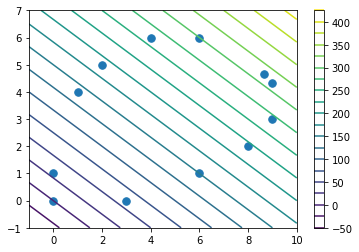

In [6]:
plt.plot(V[0,:],V[1,:],'.',ms=15)
X,Y = np.meshgrid(np.linspace(-1,10),np.linspace(-1,7))
Z = c[0]*X + c[1]*Y
plt.contour(X,Y,Z,levels=20), plt.colorbar()
plt.show()

We can see graphically that the optimal value occurs at the vertex $(8.67,4.67)$. Let's verify by computing the value of the objective function $\mathbf{c}^T \mathbf{x}$ at each vertex and to find the maximum.

In [7]:
cs = c@V
index = np.argmax(cs)
print("Optimal Solution:",V[:,index])
print("Optimal Value:",cs[index])

Optimal Solution: [8.66666667 4.66666667]
Optimal Value: 313.33333333333337


Let's use `scipy.optimize.prog` to verify.

In [8]:
linprog(-c,A,b)

     con: array([], dtype=float64)
     fun: -313.33333333079713
 message: 'Optimization terminated successfully.'
     nit: 6
   slack: array([2.23333333e+01, 7.00000000e+00, 7.33333333e+00, 1.33333333e+00,
       1.45277568e-10, 9.75042269e-11, 3.33333333e-01, 2.00000000e+00,
       4.66666667e+00, 8.33333333e+00])
  status: 0
 success: True
       x: array([8.66666667, 4.66666667])

## Compare to SciPy Algorithms

Let's write a function called `solveLP` (using our function `vertices`) which takes `c`, `A` and `b` and returns the optimal solution and value.

In [9]:
def solveLP(c,A,b):
    V = vertices(A,b)
    cs = c@V
    index = np.argmax(cs)
    return V[:,index],cs[index]

In [10]:
solveLP(c,A,b)

(array([8.66666667, 4.66666667]), 313.33333333333337)

Let's see how much faster `scipy.optimize.linprog` is for the example above compared to enumerating vertices.

In [11]:
%%timeit

solveLP(c,A,b)

7.17 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit

linprog(-c,A,b)

4 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Approximating 50% faster in this case. What happens when the size of the problem increases?

In [13]:
m = 5; n = 10;
A = np.random.randn(m,n)
b = np.random.randn(m)
c = np.random.randn(n)

In [14]:
%%timeit

solveLP(c,A,b)

236 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit

linprog(-c,A,b)

3.47 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Question.** How much faster is the HiGHs method in `scipy.optimize.linprog` compared to enumerating vertices (in terms of `m` and `n`)?

**Question.** How much faster is the HiGHs method in `scipy.optimize.linprog` compared to "interior point" method in `scipy.optimize.linprog` (in terms of `m` and `n`)?

**Question.** How do these methods work on the specially constructed "worst case" examples in the Vanderbei textbook (where the simplex method visits every vertex)?

In [16]:
%%timeit

linprog(-c,A,b,method='interior-point')

3.44 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Central Path

Let's consider the 2D problem from the beginning of the notebook again.

In [17]:
A = np.array([[-3,1],[-1,1],[-1,2],[0,1],[1,2],[.9,.9],[1,0],[1,-1],[1,-2],[1,-3]])
b = np.array([1,3,8,6,18,12,9,6,4,3])
c = np.array([20,30])

Introduce the **logarithmic barrier function** (see Vanderbei 17.1). 

In [18]:
F = lambda x,y,mu: c[0]*x + c[1]*y + mu*(np.log(x) + np.log(y)) + mu*np.sum(np.log(b - A[:,0]*x - A[:,1]*y))
F = np.vectorize(F)

Plot the contour lines for different values $\mu$ (and note that we get warnings about $\log(0)$).

/var/folders/2h/25vcwmr52mvfqs1h92028rph0000gn/T/ipykernel_78938/3619490352.py:1: RuntimeWarning: invalid value encountered in log
  F = lambda x,y,mu: c[0]*x + c[1]*y + mu*(np.log(x) + np.log(y)) + mu*np.sum(np.log(b - A[:,0]*x - A[:,1]*y))
/var/folders/2h/25vcwmr52mvfqs1h92028rph0000gn/T/ipykernel_78938/3619490352.py:1: RuntimeWarning: divide by zero encountered in log
  F = lambda x,y,mu: c[0]*x + c[1]*y + mu*(np.log(x) + np.log(y)) + mu*np.sum(np.log(b - A[:,0]*x - A[:,1]*y))


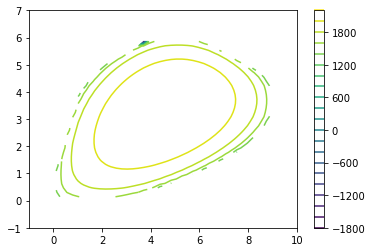

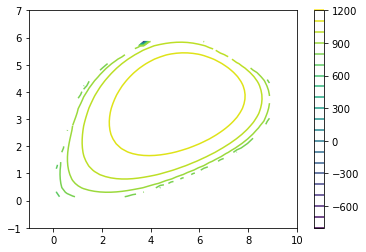

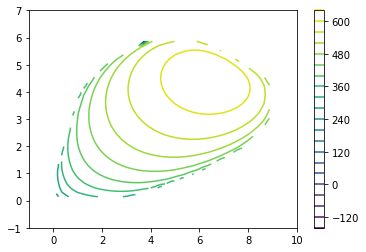

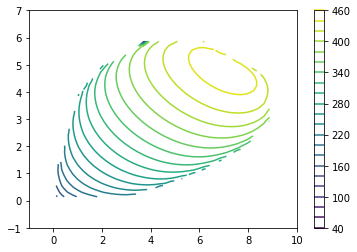

In [19]:
X,Y = np.meshgrid(np.linspace(-1,10),np.linspace(-1,7))
for mu in [100,50,20,10]:
    Z = F(X,Y,mu);
    plt.contour(X,Y,Z,levels=20), plt.colorbar();
    plt.show()

The maximum value of the logarithmic barrier function approaches the optimal solution as $\mu \to 0$. This is the called the **central path**. Let's try to compute the maximum for a small value $\mu$.

In [20]:
from scipy.optimize import minimize

mu = 5
F = lambda x: -(c[0]*x[0] + c[1]*x[1] + mu*(np.log(x[0]) + np.log(x[1])) + mu*np.sum(np.log(b - A[:,0]*x[0] - A[:,1]*x[1])))
solution = minimize(F,[7,5])

/var/folders/2h/25vcwmr52mvfqs1h92028rph0000gn/T/ipykernel_78938/218174620.py:4: RuntimeWarning: invalid value encountered in log
  F = lambda x: -(c[0]*x[0] + c[1]*x[1] + mu*(np.log(x[0]) + np.log(x[1])) + mu*np.sum(np.log(b - A[:,0]*x[0] - A[:,1]*x[1])))
/var/folders/2h/25vcwmr52mvfqs1h92028rph0000gn/T/ipykernel_78938/218174620.py:4: RuntimeWarning: invalid value encountered in log
  F = lambda x: -(c[0]*x[0] + c[1]*x[1] + mu*(np.log(x[0]) + np.log(x[1])) + mu*np.sum(np.log(b - A[:,0]*x[0] - A[:,1]*x[1])))
/var/folders/2h/25vcwmr52mvfqs1h92028rph0000gn/T/ipykernel_78938/218174620.py:4: RuntimeWarning: invalid value encountered in log
  F = lambda x: -(c[0]*x[0] + c[1]*x[1] + mu*(np.log(x[0]) + np.log(x[1])) + mu*np.sum(np.log(b - A[:,0]*x[0] - A[:,1]*x[1])))


In [21]:
solution

      fun: nan
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 336
      nit: 1
     njev: 112
   status: 2
  success: False
        x: array([634.77379679, 826.91997036])

**Question**. Why can't we just compute the maximum value of the logarithmic barrier function to solve a linear programming problem?

## Karmarkar's Algorithm

The general procedure for Karmarkar's algorithm is:

* Start with a feasible solution in the interior $\mathbf{x}_0$
* Rescale the problem by defining new variables $\mathbf{\xi} = \mathbf{x}/\mathbf{x}_0$
* Step in the direction of the gradient of the objetcive function in the scaled problem to find $\mathbf{\xi}_0$
* Unscale back to a solution $\mathbf{x}_1$ of the original problem
* Repeat!

**Question.** Karmarkar's method is not widely used anymore. Why? What other interior point methods are more commonly used?